In [1]:
import pandas as pd

df = pd.read_csv("merged_transcripts_with_PHQ8.csv")
print(f"✅ Loaded {df.shape[0]} rows")


✅ Loaded 108 rows


In [2]:
!pip install stanza networkx conllu


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 108.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 41.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu1

In [3]:
import stanza
import networkx as nx
from conllu import parse
from measures import Compute_measures

stanza.download('en')
nlp = stanza.Pipeline(lang='en', processors='tokenize,mwt,pos,lemma,depparse')


INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Downloading default packages for language: en (English) ...


INFO:stanza:Downloaded file to /root/stanza_resources/en/default.zip
INFO:stanza:Finished downloading models and saved to /root/stanza_resources
INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Loading these models for language: en (English):
| Processor | Package           |
---------------------------------
| tokenize  | combined          |
| mwt       | combined          |
| pos       | combined_charlm   |
| lemma     | combined_nocharlm |
| depparse  | combined_charlm   |

INFO:stanza:Using device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: mwt
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Loading: depparse
INFO:stanza:Done loading processors!


In [4]:
def stanza_doc_to_conllu(doc):
    conllu_str = ""
    for sent in doc.sentences:
        for i, word in enumerate(sent.words):
            conllu_str += f"{i+1}\t{word.text}\t{word.lemma}\t{word.upos}\t{word.xpos}\t{word.feats or '_'}\t{word.head}\t{word.deprel}\t_\t_\n"
        conllu_str += "\n"
    return parse(conllu_str)

def extract_survey_features(doc):
    conllu_sents = stanza_doc_to_conllu(doc)
    all_feats = {
        'arity_max': 0, 'arity_avg': 0, 'tree_depth': 0, 'num_edges': 0,
        'projective_edges': 0, 'nonprojective_edges': 0, 'gap_degree': 0,
        'first_person_pronouns': 0, 'third_person_pronouns': 0,
        'verb_repetition': 0, 'discourse_topic_switches': 0,
        'looping_topic_mentions': 0
    }

    n_sent = 0
    all_verbs = set()
    prev_topic = None
    seen_topics = set()
    topic_returned = 0

    for sent in doc.sentences:
        n_sent += 1
        sent_verbs = set()
        sent_topics = set()
        for word in sent.words:
            lemma = word.lemma.lower() if word.lemma else ""
            upos = word.upos
            if upos == 'PRON':
                if lemma in ['i', 'me', 'my', 'mine', 'myself']:
                    all_feats['first_person_pronouns'] += 1
                elif lemma in ['he', 'she', 'they', 'him', 'her', 'them', 'his', 'hers', 'their', 'theirs']:
                    all_feats['third_person_pronouns'] += 1
            elif upos == 'VERB':
                sent_verbs.add(lemma)
            if upos in ['NOUN', 'PROPN']:
                sent_topics.add(lemma)

        all_feats['verb_repetition'] += len(all_verbs.intersection(sent_verbs))
        all_verbs.update(sent_verbs)

        if prev_topic and prev_topic not in sent_topics:
            all_feats['discourse_topic_switches'] += 1
        if prev_topic and prev_topic in sent_topics:
            topic_returned += 1
        if sent_topics:
            seen_topics.update(sent_topics)
            prev_topic = list(sent_topics)[0]

    all_feats['looping_topic_mentions'] = topic_returned

    n_valid = 0
    for sent in conllu_sents:
        G = nx.DiGraph()
        for token in sent:
            if token['head'] is not None:
                G.add_node(token['id'], **token)
                if token['head'] != 0:
                    G.add_edge(token['head'], token['id'])
        G.add_node(0)
        for token in sent:
            if token['head'] == 0:
                G.add_edge(0, token['id'])

        try:
            M = Compute_measures(G)
            n_valid += 1
            all_feats['arity_max'] += M.arity()[0]
            all_feats['arity_avg'] += M.arity()[1]
            all_feats['tree_depth'] += M.projection_degree(0)
            all_feats['num_edges'] += len(G.edges)
            all_feats['projective_edges'] += sum(1 for e in G.edges if M.is_projective(e))
            all_feats['nonprojective_edges'] += sum(1 for e in G.edges if not M.is_projective(e))
            all_feats['gap_degree'] += M.gap_degree(0)
        except:
            continue

    for k in ['arity_max', 'arity_avg', 'tree_depth', 'num_edges', 'projective_edges', 'nonprojective_edges', 'gap_degree']:
        all_feats[k] /= max(n_valid, 1)

    return all_feats


In [5]:
import os
import time

features = []
output_csv = "features_progress.csv"
processed_ids = set()

# If file exists, load previous progress
if os.path.exists(output_csv):
    df_prev = pd.read_csv(output_csv)
    processed_ids = set(df_prev['Participant_ID'].tolist())
    features = df_prev.to_dict('records')
    print(f"🔁 Resuming from previous {len(processed_ids)} participants")

# Main loop
for i, row in df.iterrows():
    pid = row['Participant_ID']
    if pid in processed_ids:
        continue

    try:
        doc = nlp(row['Merged_Text'])
        feats = extract_survey_features(doc)
        feats['Participant_ID'] = pid
        feats['PHQ_8Total'] = row['PHQ_8Total']
        features.append(feats)

        # Save after each participant
        pd.DataFrame(features).to_csv(output_csv, index=False)
        print(f"✅ Saved {pid} ({len(features)} total)")
    except Exception as e:
        print(f"❌ Failed {pid}: {e}")
        continue


✅ Saved 300 (1 total)
✅ Saved 302 (2 total)
✅ Saved 303 (3 total)
✅ Saved 304 (4 total)
✅ Saved 305 (5 total)
✅ Saved 306 (6 total)
✅ Saved 307 (7 total)
✅ Saved 308 (8 total)
✅ Saved 309 (9 total)
✅ Saved 310 (10 total)
✅ Saved 312 (11 total)
✅ Saved 313 (12 total)
✅ Saved 314 (13 total)
✅ Saved 315 (14 total)
✅ Saved 316 (15 total)
✅ Saved 317 (16 total)
✅ Saved 318 (17 total)
✅ Saved 319 (18 total)
✅ Saved 320 (19 total)
✅ Saved 321 (20 total)
✅ Saved 322 (21 total)
✅ Saved 323 (22 total)
✅ Saved 324 (23 total)
✅ Saved 325 (24 total)
✅ Saved 326 (25 total)
✅ Saved 327 (26 total)
✅ Saved 328 (27 total)
✅ Saved 329 (28 total)
✅ Saved 330 (29 total)
✅ Saved 331 (30 total)
✅ Saved 332 (31 total)
✅ Saved 333 (32 total)
✅ Saved 334 (33 total)
✅ Saved 335 (34 total)
✅ Saved 336 (35 total)
✅ Saved 337 (36 total)


KeyboardInterrupt: 

In [6]:
import pandas as pd

df = pd.read_csv("features_progress.csv")
print("✅ Loaded features:", df.shape)
df.head()


✅ Loaded features: (36, 14)


,arity_max,arity_avg,tree_depth,num_edges,projective_edges,nonprojective_edges,gap_degree,first_person_pronouns,third_person_pronouns,verb_repetition,discourse_topic_switches,looping_topic_mentions,Participant_ID,PHQ_8Total
0,11.000000,0.997041,21.0,337.000000,320.000000,17.000000,2.000000,38,3,0,0,0,300,2
1,9.500000,0.995586,15.5,314.500000,298.000000,16.500000,2.500000,39,6,5,1,0,302,4
2,14.000000,0.998967,85.5,1012.000000,972.000000,40.000000,14.500000,149,45,25,0,1,303,0
3,11.500000,0.998081,29.0,524.500000,499.500000,25.000000,3.500000,101,30,16,1,0,304,6
4,9.857143,0.991553,34.0,472.285714,456.142857,16.142857,3.714286,347,37,110,5,1,305,7


In [7]:
df['label'] = (df['PHQ_8Total'] >= 10).astype(int)

X = df.drop(columns=['Participant_ID', 'PHQ_8Total', 'label'])
y = df['label']


In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [9]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [10]:
from sklearn.metrics import classification_report

y_pred = clf.predict(X_test)

print("📊 Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=["Not Depressed", "Depressed"]))


📊 Classification Report:

               precision    recall  f1-score   support

Not Depressed       0.86      1.00      0.92         6
    Depressed       1.00      0.50      0.67         2

     accuracy                           0.88         8
    macro avg       0.93      0.75      0.79         8
 weighted avg       0.89      0.88      0.86         8



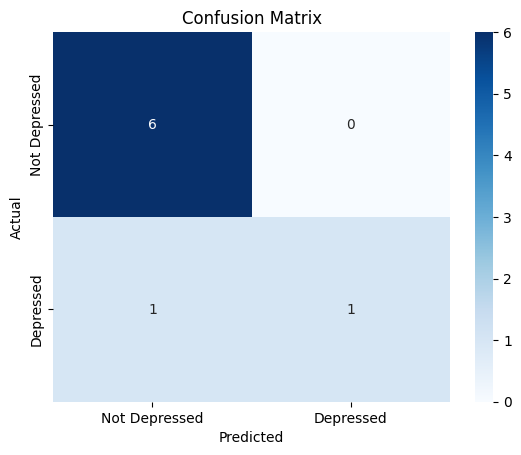

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Depressed", "Depressed"], yticklabels=["Not Depressed", "Depressed"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [12]:
import joblib

joblib.dump(clf, "final_depression_model.joblib")
df.to_csv("final_depression_features.csv", index=False)

print("✅ Model and features saved.")


✅ Model and features saved.


In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Predictions
y_pred = clf.predict(X_test)

# Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Display
print("📊 Model Evaluation Metrics:")
print(f"✅ Accuracy : {accuracy:.4f}")
print(f"✅ Precision: {precision:.4f}")
print(f"✅ Recall   : {recall:.4f}")
print(f"✅ F1-score : {f1:.4f}")


📊 Model Evaluation Metrics:
✅ Accuracy : 0.8750
✅ Precision: 1.0000
✅ Recall   : 0.5000
✅ F1-score : 0.6667


In [14]:
from sklearn.metrics import classification_report

with open("model_evaluation_report.txt", "w") as f:
    f.write("📊 Model Evaluation Metrics:\n")
    f.write(f"✅ Accuracy : {accuracy:.4f}\n")
    f.write(f"✅ Precision: {precision:.4f}\n")
    f.write(f"✅ Recall   : {recall:.4f}\n")
    f.write(f"✅ F1-score : {f1:.4f}\n\n")
    f.write("🔎 Classification Report:\n")
    f.write(classification_report(y_test, y_pred, target_names=["Not Depressed", "Depressed"]))


In [15]:
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Not Depressed", "Depressed"],
            yticklabels=["Not Depressed", "Depressed"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig("confusion_matrix.png")
plt.close()


In [17]:
from sklearn.metrics import roc_curve, auc

# Calculate ROC curve and AUC
y_prob = clf.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.tight_layout()
plt.savefig("roc_curve.png")
plt.close()

In [18]:
from google.colab import files

files.download("model_evaluation_report.txt")
files.download("confusion_matrix.png")
files.download("roc_curve.png")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [19]:
files.download("final_depression_model.joblib")
files.download("final_depression_features.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/tmp/ipython-input-20-1235204868.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[sorted_idx][:top_n], y=feature_names[sorted_idx][:top_n], palette="viridis")


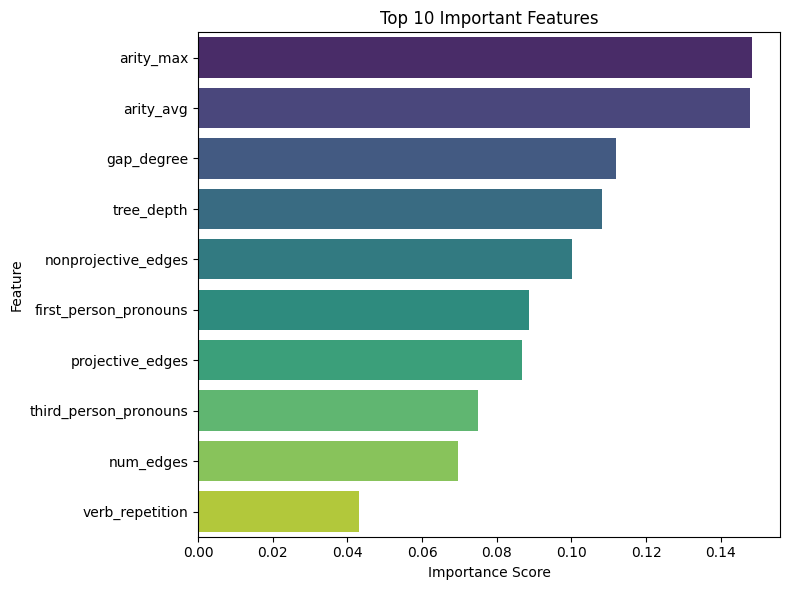

In [20]:
import numpy as np

importances = clf.feature_importances_
feature_names = X.columns

sorted_idx = np.argsort(importances)[::-1]
top_n = 10  # Top 10 features

plt.figure(figsize=(8, 6))
sns.barplot(x=importances[sorted_idx][:top_n], y=feature_names[sorted_idx][:top_n], palette="viridis")
plt.title("Top 10 Important Features")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


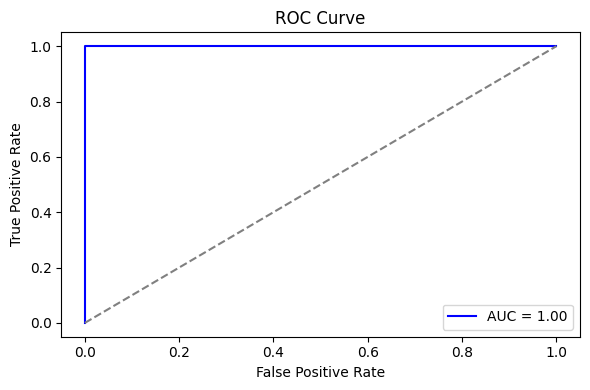

In [21]:
from sklearn.metrics import roc_curve, roc_auc_score

y_proba = clf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.tight_layout()
plt.show()
